In [1]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.stem import PorterStemmer # for stemming
from nltk.stem import WordNetLemmatizer # for lemmatization
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split , cross_val_score,KFold
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
import warnings
!pip install imblearn
import imblearn
warnings.filterwarnings("ignore")

In [2]:
!pip install transformers
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import transformers
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import logging
logging.basicConfig(level=logging.ERROR)


In [3]:
import torch
from tqdm.notebook import tqdm
!pip install transformers
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from transformers import BertForSequenceClassification
!pip install numba & conda install cudatoolkit

/bin/bash: line 1: conda: command not found


In [4]:
# Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [5]:
data = pd.read_fwf('train.txt', sep=" ", header=None, names=[ "id", "label", "tweet"] , encoding='UTF-8')


In [6]:
data.shape
data.head(100)

,id,label,tweet
0,1247415049444089856,1,@ProfGlantz: Frequently asked questions about ...
1,1247417054740639746,1,@mauiwowie_bunny: i swear it’s from smoking we...
2,1247418552870522880,1,@TSaffronist: @sterlite_copper Police and doct...
3,1247418623498452992,1,@BhakthLokesh @chetan_bhagat Somewhere in Indi...
4,1247419722456391680,1,Govt. Should take immediate steps to stop blac...
...,...,...,...
95,1247550012533477376,1,I just bought Corona and my favorite wine. Qua...
96,1247550533306421249,1,non-stop liquor consumption boosts our immune ...
97,1247551163924230144,1,@FaizKazi14 You can never think in the long ru...
98,1247551676984295428,1,"@BrezhMalaba how viable is tobacco farming, in..."


In [7]:
data['label'].unique()

array([1, 0])

In [8]:
data.describe()

,id,label
count,1.892000e+03,1892.000000
mean,1.258375e+18,0.500000
std,2.797167e+16,0.500132
min,1.265564e+17,0.000000
25%,1.250089e+18,0.000000
50%,1.262661e+18,0.500000
75%,1.268041e+18,1.000000
max,1.275676e+18,1.000000


In [9]:
new_df = data[['label', 'tweet']]
new_df.head()

,label,tweet
0,1,@ProfGlantz: Frequently asked questions about ...
1,1,@mauiwowie_bunny: i swear it’s from smoking we...
2,1,@TSaffronist: @sterlite_copper Police and doct...
3,1,@BhakthLokesh @chetan_bhagat Somewhere in Indi...
4,1,Govt. Should take immediate steps to stop blac...


In [10]:
from transformers import BertModel, BertTokenizer


In [11]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 256
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
# EPOCHS = 1
LEARNING_RATE = 1e-05
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', truncation=True, do_lower_case=True)

In [12]:
class SentimentData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.tweet
        self.targets = self.data.label
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [13]:
train_size = 0.85
train_data=new_df.sample(frac=train_size,random_state=200)
validation_data=new_df.drop(train_data.index).reset_index(drop=True)
train_data = train_data.reset_index(drop=True)

print("FULL Dataset: {}".format(new_df.shape))
print("TRAIN Dataset: {}".format(train_data.shape))
print("validation Dataset: {}".format(validation_data.shape))
training_set = SentimentData(train_data, tokenizer, MAX_LEN)
testing_set = SentimentData(validation_data, tokenizer, MAX_LEN)

FULL Dataset: (1892, 2)
TRAIN Dataset: (1608, 2)
validation Dataset: (284, 2)


In [14]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [15]:
class BertClass(torch.nn.Module):
    def __init__(self):
        super(BertClass, self).__init__()
        self.l1 = BertModel.from_pretrained("bert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 5)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [16]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [17]:
model = BertClass()
model.to(device)

BertClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

In [18]:
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [19]:
from sklearn.metrics import precision_score,recall_score,accuracy_score, f1_score
def show_confusion(label,pred_label,nm):
  class_names=['No-Addiction','Addiction']
  cm=confusion_matrix(label,pred_label)
  disp =ConfusionMatrixDisplay(cm,display_labels=class_names)
  disp.plot()
  plt.title(f'Confusion Matrix {nm}')
  plt.xlabel('Actual')
  plt.ylabel('Predicted')
  plt.show()

def mymetrics(Y,P , alg = None):
    recall= recall_score(Y, P)
    acc2= accuracy_score(Y, P)
    precision= precision_score(Y, P)
    Fmeasure = f1_score(Y, P)
    print(f"accuracy = {acc2*100}")
    print(f'recall= {recall*100}')
    print(f'precision= {precision*100}')
    print(f'Fmeasure= {Fmeasure*100}')

In [20]:
def calcuate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct

In [21]:
# Defining the training function on the 80% of the dataset for tuning the distilbert model

def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in tqdm(enumerate(training_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask, token_type_ids)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accuracy(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)

        if _%5000==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples
            print(f"Training Loss per 5000 steps: {loss_step}")
            print(f"Training Accuracy per 5000 steps: {accu_step}")

        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")


    return

In [22]:
EPOCHS = 5
for epoch in range(EPOCHS):
    train(epoch)

0it [00:00, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Training Loss per 5000 steps: 1.6112686395645142
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 0: 74.81343283582089
Training Loss Epoch: 0.6533372510057777
Training Accuracy Epoch: 74.81343283582089


0it [00:00, ?it/s]

Training Loss per 5000 steps: 0.359691858291626
Training Accuracy per 5000 steps: 87.5
The Total Accuracy for Epoch 1: 96.01990049751244
Training Loss Epoch: 0.15281760969676486
Training Accuracy Epoch: 96.01990049751244


0it [00:00, ?it/s]

Training Loss per 5000 steps: 0.03688829392194748
Training Accuracy per 5000 steps: 100.0
The Total Accuracy for Epoch 2: 97.76119402985074
Training Loss Epoch: 0.08836652661455953
Training Accuracy Epoch: 97.76119402985074


0it [00:00, ?it/s]

Training Loss per 5000 steps: 0.02778834104537964
Training Accuracy per 5000 steps: 100.0
The Total Accuracy for Epoch 3: 98.6318407960199
Training Loss Epoch: 0.05444023081921597
Training Accuracy Epoch: 98.6318407960199


0it [00:00, ?it/s]

Training Loss per 5000 steps: 0.011809759773314
Training Accuracy per 5000 steps: 100.0
The Total Accuracy for Epoch 4: 99.68905472636816
Training Loss Epoch: 0.021397532285909304
Training Accuracy Epoch: 99.68905472636816


In [23]:
torch.save(model.state_dict(), 'saved_weights.pt')

In [24]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report


def valid(model, testing_loader):
   # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  all_logits=[]
  all_labels=[]
  # Evaluate data for one epoch
  for _,data in tqdm(enumerate(testing_loader, 0)):
    ids = data['ids'].to(device, dtype = torch.long)
    mask = data['mask'].to(device, dtype = torch.long)
    token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
    targets = data['targets'].to(device, dtype = torch.long)


    with torch.no_grad():
      # Forward pass, calculate logit predictions
      output = model(ids, mask, token_type_ids)
      logits = output

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = targets.to('cpu').numpy()
    all_logits.extend(np.argmax(logits, axis=1).flatten())
    all_labels.extend(label_ids)
  accuracy = accuracy_score(all_logits , all_labels)


  val_f1 = f1_score(all_logits, all_labels)
  val_precision = precision_score(all_logits, all_labels)
  val_recall = recall_score(all_logits, all_labels)

  show_confusion(all_logits, all_labels,'Bert')




  y = classification_report(all_labels,all_logits,digits=4)
  print(y)

*****validation acuracy*******


0it [00:00, ?it/s]

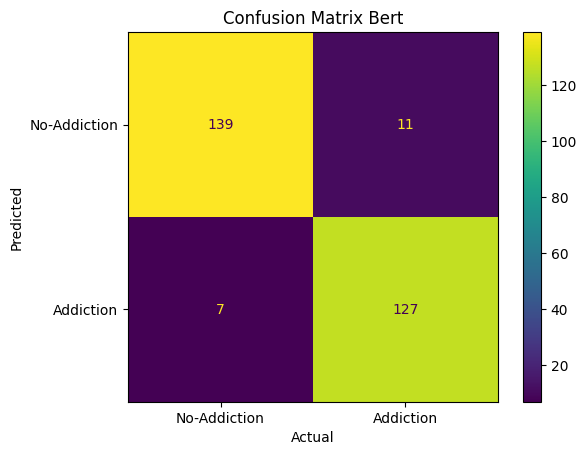

              precision    recall  f1-score   support

           0     0.9267    0.9521    0.9392       146
           1     0.9478    0.9203    0.9338       138

    accuracy                         0.9366       284
   macro avg     0.9372    0.9362    0.9365       284
weighted avg     0.9369    0.9366    0.9366       284



In [25]:
print("*****validation acuracy*******")
valid(model, testing_loader)

In [26]:
test_data2 = pd.read_fwf('test.txt', sep=" ", header=None, names=[ "id", "label", "tweet"] , encoding='UTF-8')


In [27]:
test_data2 = test_data2[['label', 'tweet']]
test_data2.head()

,label,tweet
0,1,"infoJATIASIH ""Dexamethasone seems to be promis..."
1,1,Coronavirus: Steroid dexamethasone can help sa...
2,1,@moreni_kej: Dexamethasone is a corticosteroid...
3,1,@DrMunster: Dexamethasone: the preferred stero...
4,1,An expert committee in Pakistan will consider ...


*****test acuracy*******


0it [00:00, ?it/s]

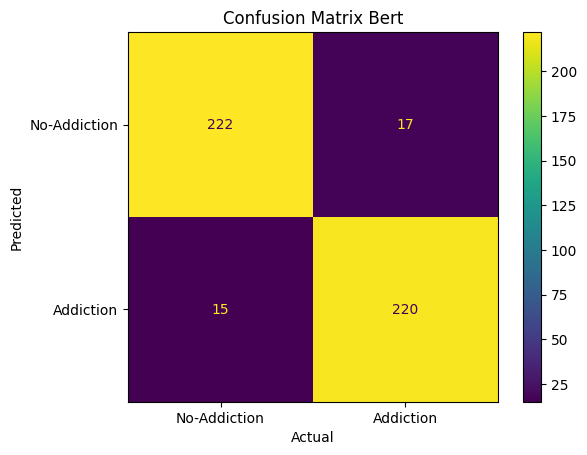

              precision    recall  f1-score   support

           0     0.9289    0.9367    0.9328       237
           1     0.9362    0.9283    0.9322       237

    accuracy                         0.9325       474
   macro avg     0.9325    0.9325    0.9325       474
weighted avg     0.9325    0.9325    0.9325       474



In [28]:
testing_set2 = SentimentData(test_data2, tokenizer, MAX_LEN)
testing_loader2 = DataLoader(testing_set2, **test_params)


print("*****test acuracy*******")
valid(model, testing_loader2)